# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: LightGBM Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. LightGBM Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'tree_learner': 'data', 'objective': 'binary', 'num_leaves': 8, 'n_estimators': 50, 'max_depth': -1, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'device': 'cpu', 'data_sample_strategy': 'goss', 'class_weight': 'balanced', 'boosting_type': 'gbdt', 'boost_from_average': False}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `n_jobs`, and `verbose` as the values for these are hardcoded to the notebook.**

In [1]:
MODEL_FILENAME = "Test" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = True # <== Set as True if you'll be training a tuned model.

TB_HYPERPARAMS = "{'tree_learner': 'data', 'objective': 'binary', 'num_leaves': 8, 'n_estimators': 50, 'max_depth': -1, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'device': 'cpu', 'data_sample_strategy': 'goss', 'class_weight': 'balanced', 'boosting_type': 'gbdt', 'boost_from_average': False}"
IB_HYPERPARAMS = "{'tree_learner': 'data', 'objective': 'binary', 'num_leaves': 8, 'n_estimators': 50, 'max_depth': -1, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'device': 'cpu', 'data_sample_strategy': 'goss', 'class_weight': 'balanced', 'boosting_type': 'gbdt', 'boost_from_average': False}"

TB_HYPERPARAMS_FILE = "Outputs/TEST_TUNE_TB_LGBM.tune" # <== Pointing a file; Overrides the value set above. 
IB_HYPERPARAMS_FILE = "Outputs/TEST_TUNE_IB_LGBM.tune" # <== Pointing a file; Overrides the value set above. 

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Think of this as a seed generator which allows for a more consistent "randomization" which also applies on other areas of the study (i.e., dataset, tuning, and eval)

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [2]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [3]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
    
start = end = 0
LOG_FILENAME = "LGBM_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def startTime():
    global start
    start = time.time()
def endTime(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

Parsed TB Hyperparams: {'tree_learner': 'data', 'objective': 'binary', 'num_leaves': 31, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.3, 'l2_leaf_reg': 2, 'device': 'gpu', 'data_sample_strategy': 'goss', 'class_weight': 'balanced', 'boosting_type': 'gbdt', 'boost_from_average': 'True'}
Parsed IB Hyperparams: {'tree_learner': 'data', 'objective': 'binary', 'num_leaves': 31, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.3, 'l2_leaf_reg': 2, 'device': 'gpu', 'data_sample_strategy': 'goss', 'class_weight': 'balanced', 'boosting_type': 'gbdt', 'boost_from_average': 'True'}


## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [4]:
#Setting filenames of files
TB_Train = "../Dataset/TB/TB_LGBM.csv" # <== Location for Time-based Train Split for LightGBM
#TB_Test = "../Dataset/TB/TB_Test_LGBM.csv" # <== Location for Time-based Test Split for LightGBM
IB_Train = "../Dataset/IB/IB_LGBM.csv" # <== Location for Instance-based Train Split for LightGBM
#IB_Test = "../Dataset/IB/IB_Test_LGBM.csv" # <== Location for Instance-based Test Split for LightGBM

### 1.3.2. Loading datasets to DataFrames

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (4574, 101)
IB Train Size: (4574, 101)


### 1.3.3. Previewing datasets

In [6]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,134,93,162,95,153,170,153,134,135,...,154,153,232,219,236,219,232,219,236,219
1,1,95,153,170,153,134,135,134,135,134,...,72,153,170,72,153,170,72,153,170,72
2,1,136,135,136,135,136,135,136,135,136,...,153,136,135,136,135,136,135,136,135,136
3,1,95,136,135,136,135,136,135,136,135,...,236,232,236,232,236,232,236,232,236,232
4,1,95,136,135,136,135,136,135,136,135,...,135,94,134,135,92,136,25,59,154,94


In [7]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,134,93,162,95,153,170,135,26,270,...,148,148,148,148,148,148,148,148,148,148
1,1,95,153,170,134,135,262,92,162,136,...,148,148,148,148,148,148,148,148,148,148
2,1,136,135,183,154,177,191,134,93,153,...,148,148,148,148,148,148,148,148,148,148
3,1,95,136,135,134,262,28,177,191,154,...,148,148,148,148,148,148,148,148,148,148
4,1,95,136,135,134,262,248,254,76,18,...,148,148,148,148,148,148,148,148,148,148


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [8]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True)

# 2. Model Training

## 2.1. Setting up the Model

In [9]:
def getIndexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setupModel(HYPERPARAMS):
    global TUNED_TRAINING
    if TUNED_TRAINING:
        return lightgbm.LGBMClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, n_jobs=-1, verbose=1, categorical_data=getIndexes())
    return lightgbm.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)

## 2.2. Training on Time-Based Behaviors

### 2.2.1. Training the Model

In [10]:
#Training Model
startTime()
tb_lgbm = setupModel(TB_HYPERPARAMS)
tb_lgbm.fit(X_tb_training, y_tb_training)
endTime("TB_LGBM")

#Saving Model as file
dump(tb_lgbm, "Outputs/"+MODEL_FILENAME+"_TB_LGBM.model")

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Info] Number of positive: 1590, number of negative: 1611
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4809
[LightGBM] [Info] Number of data points in the train set: 3201, number of used features: 100
[LightGBM] [Info] Using GPU Device: gfx902, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 98 dense feature groups (0.31 MB) transferred to GPU in 0.009592 secs. 1 sparse feature groups
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 98 dense feature groups (0.09 MB) transferred to GPU in 0.009348 secs. 1 spar

[LightGBM] [Info] 98 dense feature groups (0.09 MB) transferred to GPU in 0.008432 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 98 dense feature groups (0.09 MB) transferred to GPU in 0.007825 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 98 dense feature groups (0.09 MB) transferred to GPU in 0.007333 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 98 dense feature groups (0.09 MB) transferred to GPU in 0.007717 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 98 dense feature groups (0.09 MB) 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 98 dense feature groups (0.09 MB) transferred to GPU in 0.007527 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 98 dense feature groups (0.09 MB) transferred to GPU in 0.007449 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 98 dense feature groups (0.09 MB) transferred to GPU in 0.009038 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 98 dense feature groups (0.09 MB) transferred to GPU in 0.008387 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive

['Outputs/TUNED_Test_TB_LGBM.model']

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

In [11]:
print(classification_report(y_tb_validate, tb_lgbm.predict(X_tb_validate),digits=4))

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
              precision    recall  f1-score   support

           0     0.9970    0.9882    0.9926       676
           1     0.9886    0.9971    0.9929       697

    accuracy                         0.9927      1373
   macro avg     0.9928    0.9926    0.9927      1373
weighted avg     0.9928    0.9927    0.9927      1373



### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

<Axes: >

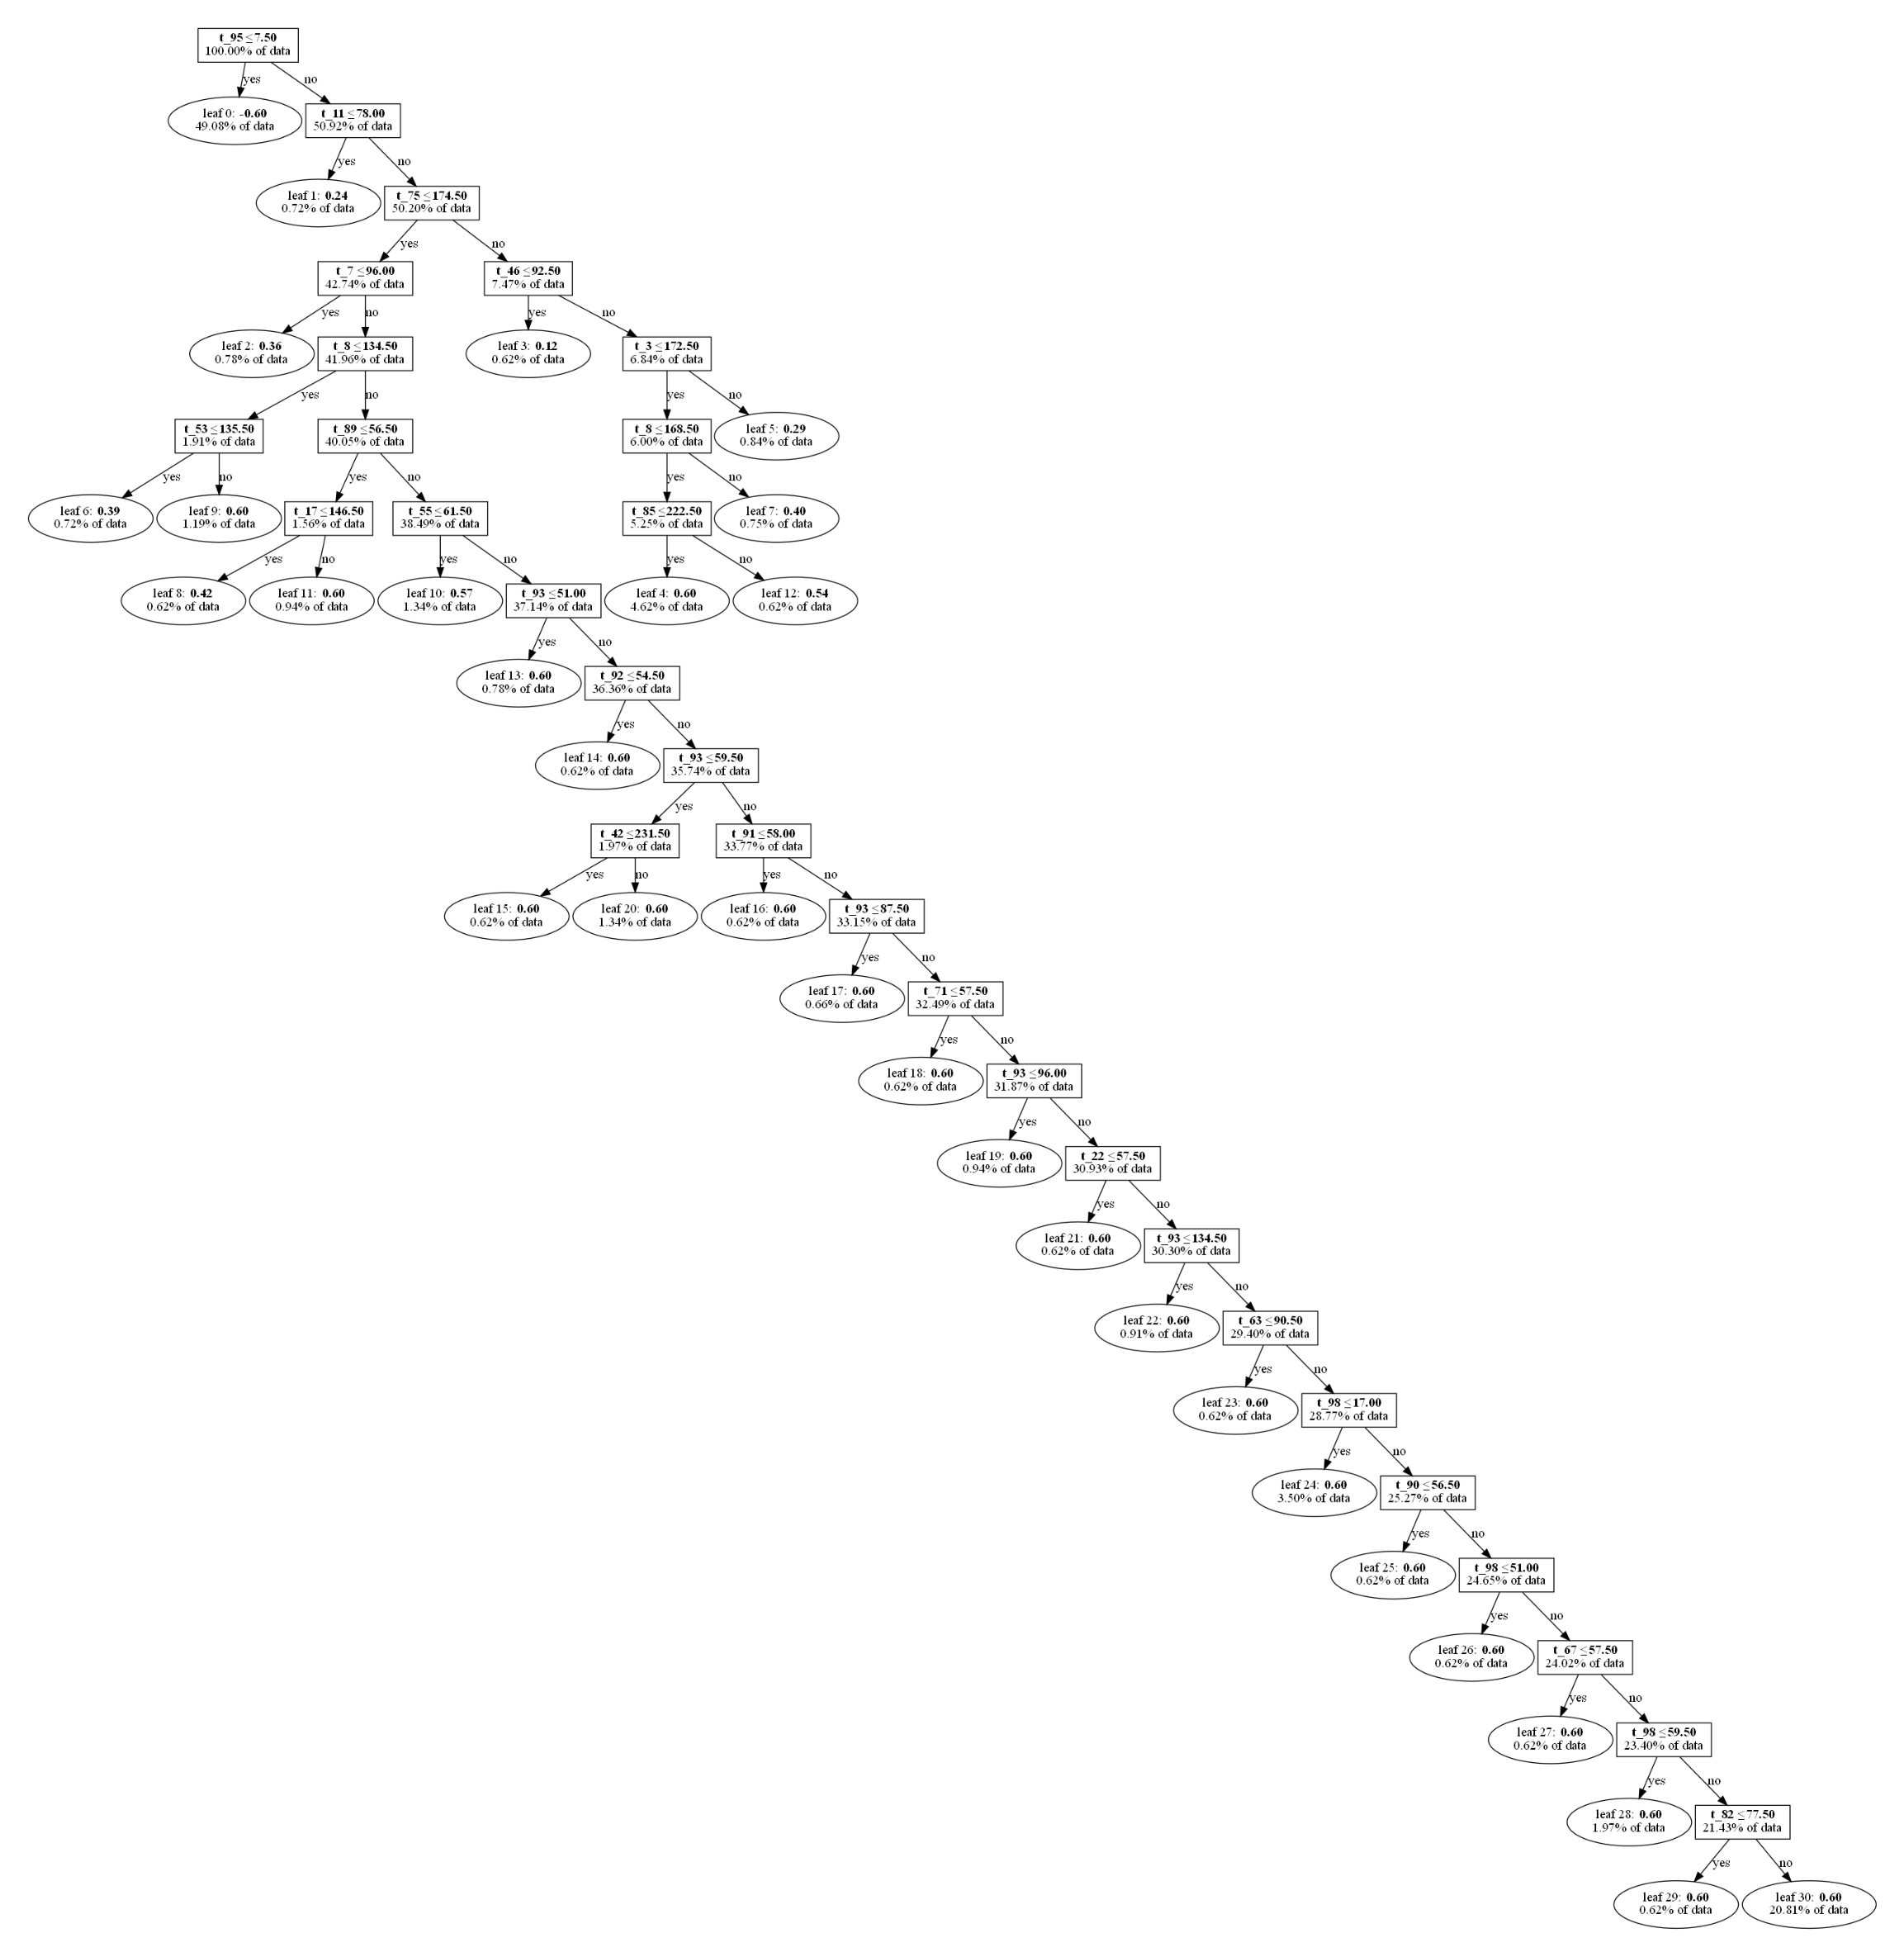

In [12]:
#One of the many layers of LGBM (1st layer)
lightgbm.plot_tree(tb_lgbm, figsize=(10,10), dpi=300, show_info='data_percentage', precision=2, orientation='vertical')

## 2.3. Training on Instance-Based Behaviors

### 2.3.1. Training the Model

In [13]:
#Training Model
startTime()
ib_lgbm = setupModel(IB_HYPERPARAMS)
ib_lgbm.fit(X_ib_training, y_ib_training)
endTime("IB_LGBM")

#Saving Model as file
dump(ib_lgbm, "Outputs/"+MODEL_FILENAME+"_IB_LGBM.model")

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Info] Number of positive: 1629, number of negative: 1572
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1559
[LightGBM] [Info] Number of data points in the train set: 3201, number of used features: 34
[LightGBM] [Info] Using GPU Device: gfx902, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (0.07 MB) transferred to GPU in 0.004293 secs. 1 sparse feature groups
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (0.05 MB) transferred to GPU in 0.003537 secs. 1 sparse

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (0.02 MB) transferred to GPU in 0.004332 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (0.02 MB) transferred to GPU in 0.003251 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (0.02 MB) transferred to GPU in 0.003314 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (0.02 MB) transferred to GPU in 0.003592 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (0.02 MB) transferred to GPU in 0.003863 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (0.02 MB) transferred to GPU in 0.004215 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (0.02 MB) transferred to GPU in 0.004122 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (0.02 MB) transferred to GPU in 0.004395 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive

['Outputs/TUNED_Test_IB_LGBM.model']

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

In [14]:
print(classification_report(y_ib_validate, ib_lgbm.predict(X_ib_validate),digits=4))

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
              precision    recall  f1-score   support

           0     1.0000    0.9762    0.9880       715
           1     0.9748    1.0000    0.9872       658

    accuracy                         0.9876      1373
   macro avg     0.9874    0.9881    0.9876      1373
weighted avg     0.9879    0.9876    0.9876      1373



### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

<Axes: >

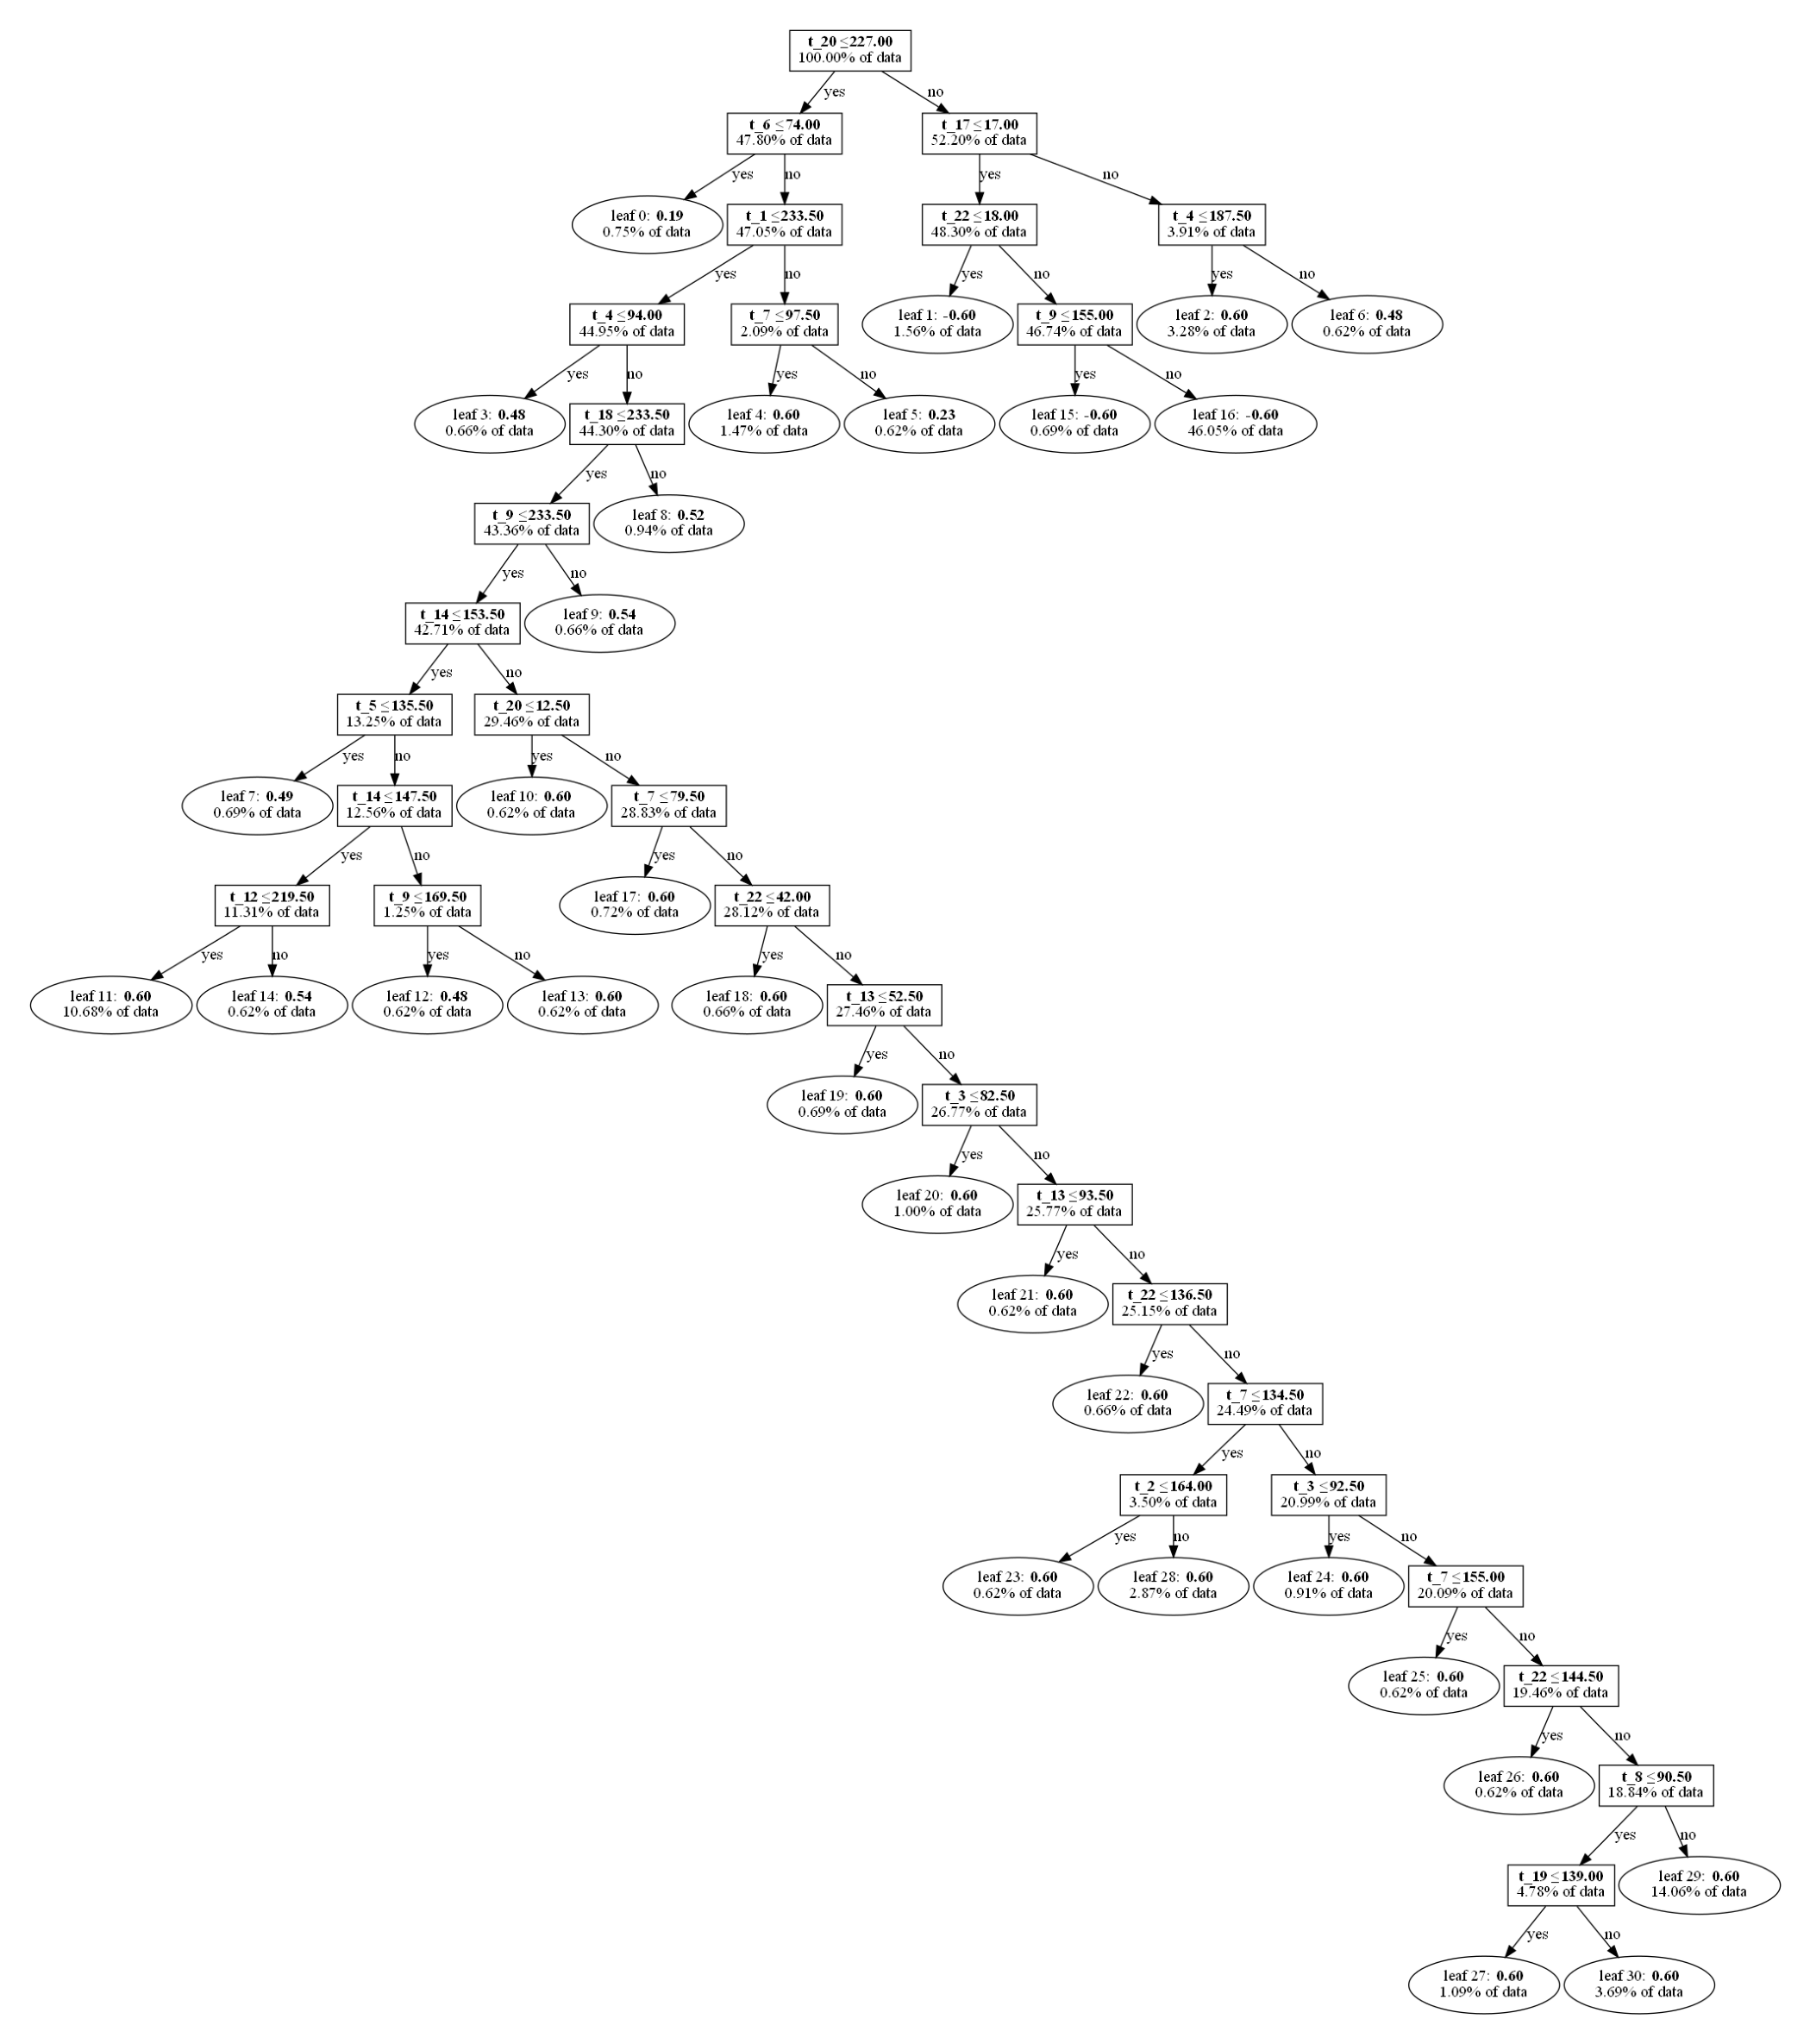

In [15]:
#One of the many layers of LGBM (1st layer)
lightgbm.plot_tree(ib_lgbm, figsize=(10,10), dpi=300, show_info='data_percentage', precision=2, orientation='vertical')

In [16]:
logging("\n")